In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks')

In [3]:
import pytorch_optimizer as optim

In [4]:
import torch
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [5]:
import torchvision.datasets
from tqdm import tqdm

In [6]:
CIFAR_train = torchvision.datasets.CIFAR100('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR100('./', download=True, train=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [7]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [8]:
len(y_train), len(y_test)

(50000, 10000)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [10]:
X_train /= 255.
X_test /= 255.

In [11]:
CIFAR_train.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

tensor(19) tensor(29) tensor(0) tensor(11) tensor(1) tensor(86) tensor(90) tensor(28) tensor(23) tensor(31) 

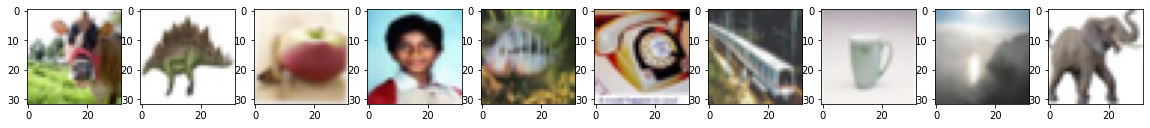

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(y_train[i], end=' ')

In [13]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [14]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [15]:
X_train.shape

torch.Size([50000, 3, 32, 32])

In [36]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=4.0e-3)
    #optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-3)
    #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-3)
    
    batch_size = 200

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        print("epoch ", epoch)
        order = np.random.permutation(len(X_train))
        
        if epoch == 17:
            print("lr=1.0e-4")
            optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-4)
            #optimizer = optim.PNMBelief(net.parameters(), lr=1.0e-4)
            #optimizer = optim.YogiPNM(net.parameters(), lr=1.0e-4)


        for start_index in tqdm(range(0, len(X_train), batch_size)):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            loss_value = loss(test_preds, y_test).item()
            test_loss_history.append(loss_value)

            accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
            test_accuracy_history.append(accuracy)
            #print(test_preds.argmax(dim=1))
            #print(y_test)

        print("accuracy = ", accuracy)
        print("\n\n")

    return test_accuracy_history, test_loss_history

In [17]:
accuracies = {}
losses = {}

In [18]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [19]:
accuracies['resnet50+PNMBelief'], losses['resnet50+PNMBelief'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 100/100 [00:28<00:00,  3.47it/s]


accuracy =  0.32330000400543213



epoch  1


100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


accuracy =  0.5374000072479248



epoch  2


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


accuracy =  0.5760999917984009



epoch  3


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


accuracy =  0.5925999879837036



epoch  4


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6021999716758728



epoch  5


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


accuracy =  0.6003999710083008



epoch  6


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


accuracy =  0.6053000092506409



epoch  7


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6062999963760376



epoch  8


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6055999994277954



epoch  9


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


accuracy =  0.5978999733924866



epoch  10


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


accuracy =  0.6083999872207642



epoch  11


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


accuracy =  0.6074999570846558



epoch  12


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6031999588012695



epoch  13


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6078999638557434



epoch  14


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


accuracy =  0.6032999753952026



epoch  15


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6150999665260315



epoch  16


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6187999844551086



epoch  17
lr=1.0e-4


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6319000124931335



epoch  18


100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


accuracy =  0.6342999935150146



epoch  19


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.636900007724762



epoch  20


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6365999579429626



epoch  21


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6366999745368958



epoch  22


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


accuracy =  0.6362999677658081



epoch  23


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6372999548912048



epoch  24


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6383000016212463



epoch  25


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6380000114440918



epoch  26


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6387999653816223



epoch  27


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6408999562263489



epoch  28


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6380999684333801



epoch  29


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6396999955177307





In [21]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [22]:
accuracies['resnet50+YogiPNM'], losses['resnet50+YogiPNM'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


accuracy =  0.3333999812602997



epoch  1


100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


accuracy =  0.5464000105857849



epoch  2


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.5983999967575073



epoch  3


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6074000000953674



epoch  4


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6128000020980835



epoch  5


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6125999689102173



epoch  6


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6180999875068665



epoch  7


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6171000003814697



epoch  8


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6164000034332275



epoch  9


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6146000027656555



epoch  10


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6211000084877014



epoch  11


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


accuracy =  0.6272000074386597



epoch  12


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6229999661445618



epoch  13


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6207999587059021



epoch  14


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6208999752998352



epoch  15


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6196999549865723



epoch  16


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6211999654769897



epoch  17
lr=1.0e-4


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6333999633789062



epoch  18


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6376000046730042



epoch  19


100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


accuracy =  0.6383999586105347



epoch  20


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


accuracy =  0.6373999714851379



epoch  21


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6401999592781067



epoch  22


100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


accuracy =  0.6403999924659729



epoch  23


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6417999863624573



epoch  24


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


accuracy =  0.6438999772071838



epoch  25


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


accuracy =  0.6412999629974365



epoch  26


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.642300009727478



epoch  27


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


accuracy =  0.6419000029563904



epoch  28


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


accuracy =  0.6416999697685242



epoch  29


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


accuracy =  0.6403999924659729





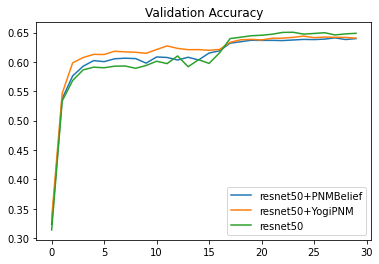

In [28]:
for experiment_id in accuracies.keys():
    plt.plot(accuracies[experiment_id], label=experiment_id)
    plt.legend()
    plt.title('Validation Accuracy');

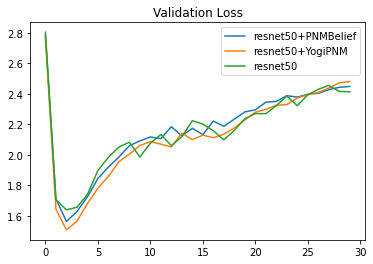

In [29]:
for experiment_id in losses.keys():
    plt.plot(losses[experiment_id], label=experiment_id)
    plt.legend()
    plt.title('Validation Loss');

In [37]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

In [38]:
accuracies['resnet50+SGD'], losses['resnet50+SGD'] = \
    train(model, X_train, y_train, X_test, y_test)

epoch  0


100%|██████████| 250/250 [00:22<00:00, 11.03it/s]


accuracy =  0.00419999985024333



epoch  1


100%|██████████| 250/250 [00:22<00:00, 10.89it/s]


accuracy =  0.00930000003427267



epoch  2


100%|██████████| 250/250 [00:22<00:00, 11.05it/s]


accuracy =  0.019999999552965164



epoch  3


100%|██████████| 250/250 [00:22<00:00, 11.12it/s]


accuracy =  0.02579999901354313



epoch  4


100%|██████████| 250/250 [00:22<00:00, 11.12it/s]


accuracy =  0.03350000083446503



epoch  5


100%|██████████| 250/250 [00:22<00:00, 11.06it/s]


accuracy =  0.048899997025728226



epoch  6


100%|██████████| 250/250 [00:22<00:00, 11.07it/s]


accuracy =  0.06969999521970749



epoch  7


100%|██████████| 250/250 [00:22<00:00, 11.07it/s]


accuracy =  0.08919999748468399



epoch  8


100%|██████████| 250/250 [00:22<00:00, 11.02it/s]


accuracy =  0.1021999940276146



epoch  9


100%|██████████| 250/250 [00:22<00:00, 11.10it/s]


accuracy =  0.12280000001192093



epoch  10


100%|██████████| 250/250 [00:22<00:00, 11.04it/s]


accuracy =  0.1551000028848648



epoch  11


100%|██████████| 250/250 [00:22<00:00, 11.06it/s]


accuracy =  0.18549999594688416



epoch  12


100%|██████████| 250/250 [00:22<00:00, 11.05it/s]


accuracy =  0.21459999680519104



epoch  13


100%|██████████| 250/250 [00:22<00:00, 11.09it/s]


accuracy =  0.2433999925851822



epoch  14


100%|██████████| 250/250 [00:22<00:00, 11.10it/s]


accuracy =  0.2669000029563904



epoch  15


100%|██████████| 250/250 [00:22<00:00, 11.04it/s]


accuracy =  0.3005000054836273



epoch  16


100%|██████████| 250/250 [00:22<00:00, 10.99it/s]


accuracy =  0.33009999990463257



epoch  17
lr=1.0e-4


100%|██████████| 250/250 [00:22<00:00, 11.07it/s]


accuracy =  0.3304999768733978



epoch  18


100%|██████████| 250/250 [00:22<00:00, 11.10it/s]


accuracy =  0.32829999923706055



epoch  19


100%|██████████| 250/250 [00:22<00:00, 11.05it/s]


accuracy =  0.3303000032901764



epoch  20


100%|██████████| 250/250 [00:22<00:00, 11.04it/s]


accuracy =  0.3296999931335449



epoch  21


100%|██████████| 250/250 [00:22<00:00, 11.05it/s]


accuracy =  0.3321000039577484



epoch  22


100%|██████████| 250/250 [00:22<00:00, 11.08it/s]


accuracy =  0.3312000036239624



epoch  23


100%|██████████| 250/250 [00:22<00:00, 11.10it/s]


accuracy =  0.3308999836444855



epoch  24


100%|██████████| 250/250 [00:22<00:00, 11.04it/s]


accuracy =  0.3312999904155731



epoch  25


100%|██████████| 250/250 [00:23<00:00, 10.81it/s]


accuracy =  0.33239999413490295



epoch  26


100%|██████████| 250/250 [00:22<00:00, 11.06it/s]


accuracy =  0.3335999846458435



epoch  27


100%|██████████| 250/250 [00:22<00:00, 11.12it/s]


accuracy =  0.33629998564720154



epoch  28


100%|██████████| 250/250 [00:22<00:00, 11.07it/s]


accuracy =  0.3333999812602997



epoch  29


100%|██████████| 250/250 [00:22<00:00, 11.06it/s]


accuracy =  0.33329999446868896



